In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import pandas as pd

from config import key_id, secret_key



In [2]:
api = tradeapi.REST(key_id, secret_key)

In [71]:
#get data and turn to dataframe form
#15Min, 5Min
data=api.get_barset(symbols = ("INTC"), start = '2020-03-27T11:52:00-04:00', end = "2020-01-01", timeframe = "minute", limit=1000)
df=data.df #converts to dataframe

In [72]:
#get rid of multiindex, otherwise backtrader will have problems
df=df.INTC

In [75]:
#previewing
df.head()

,open,high,low,close,volume
2020-03-27 11:52:00-04:00,53.930,53.930,53.920,53.920,300
2020-03-27 11:53:00-04:00,53.950,53.965,53.910,53.965,456
2020-03-27 11:54:00-04:00,54.000,54.085,53.980,54.085,561
2020-03-27 11:55:00-04:00,54.075,54.075,54.030,54.055,400
2020-03-27 11:56:00-04:00,54.070,54.070,53.975,53.975,1300


In [6]:
#feed dataframe to cerbro
datacere = bt.feeds.PandasData(dataname=df)

datacere

In [7]:
#create backtrader
cerebro = bt.Cerebro()

In [8]:
#feed strat to cerebro
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

            
class secondStrategy(bt.Strategy):
#RSI is relative strength index
    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=100)
        else:
            if self.rsi > 70:
                self.sell(size=100)

In [9]:
#for right now can only run one strat at a time

cerebro.addstrategy(SmaCross)
#cerebro.addstrategy(secondStrategy)


0

In [10]:
#set up cerebro

cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents=20)
cerebro.adddata(datacere)


In [11]:
#create plotinfo dict for plotting options
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [12]:
#change window settings
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 20, 15  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "20"

In [25]:
#Add indicators 

#adding another simple moving average line; this is the backtrader built in indicator
sma = bt.indicators.SimpleMovingAverage(datacere, period=15)
sma.plotinfo.plotname = 'mysma'


macd= bt.indicators.MACD(datacere)
macd.plotinfo.plotname="MACD"
#https://www.backtrader.com/docu/indautoref/
#custom: https://medium.com/@danjrod/custom-indicator-development-in-python-with-backtrader-bc775552dc3e

In [24]:
macd.lines.macd

In [14]:
# Add the analyzers we are interested in
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")
cerebro.addanalyzer(bt.analyzers.Returns, _name="ret")
cerebro.addanalyzer(bt.analyzers.PeriodStats, _name="pstat")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="trans")



#analyzers list and also creating own analyzer
#https://www.backtrader.com/docu/analyzers/analyzers/
#https://www.backtrader.com/docu/analyzers-reference/

In [15]:
# Add the observers we are interested in 
#this adds more things to the plot on top of the stocks chart
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)


#https://www.backtrader.com/docu/observers-and-statistics/observers-and-statistics/

<IPython.core.display.Javascript object>


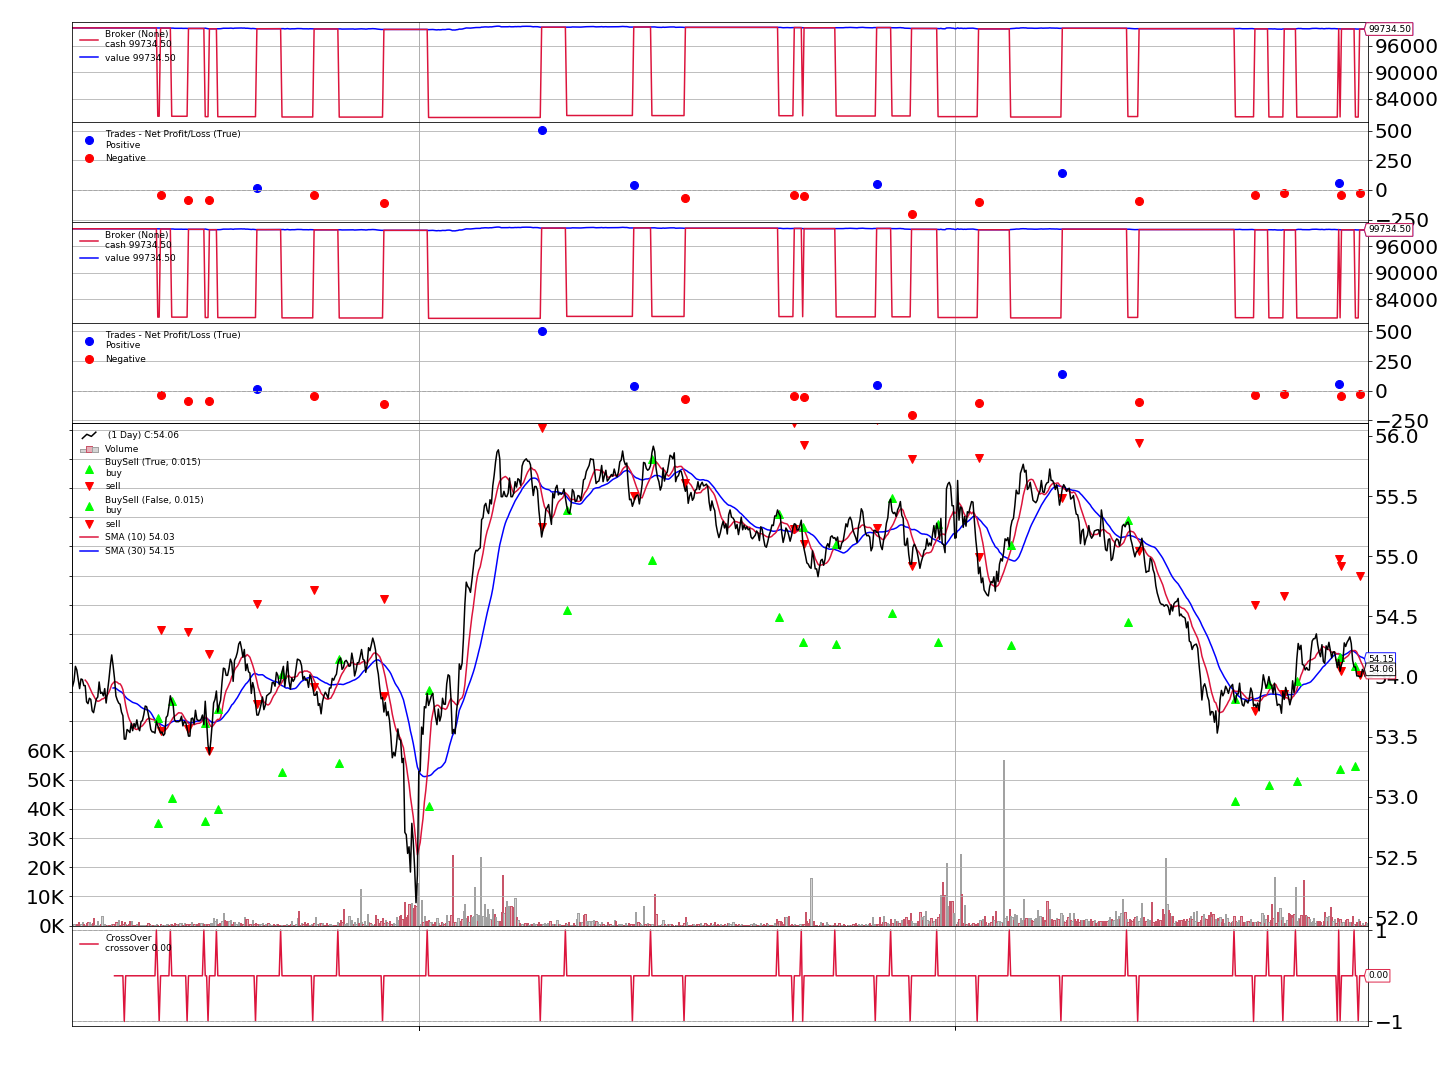

[[<Figure size 1440x1080 with 7 Axes>]]

In [26]:
# Run over everything
test=cerebro.run()

# Plot the result
cerebro.plot()


## Analyzers


In [17]:
# print the SQN analyzers  SystemQualityNumber
#test[0] is the first strategy used. For multiple strategies, use corresponding number in the list.
SQN_dict=test[0].analyzers.sqn.get_analysis() 
tradeanalysis_dict=test[0].analyzers.ta.get_analysis()
ret_dict=test[0].analyzers.ret.get_analysis()
trans_dict=test[0].analyzers.trans.get_analysis()

#.ta.get_analysis()
    #printSQN(firstStrat.analyzers.sqn.get_analysis())

    
#The Backtrader documentation provides a helpful ranking system for SQN:
#SQN measures the relationship between the mean (expectancy) and the standard deviation of the R-multiple distribution 
#generated by a trading system. It also makes an adjustment for the number of trades involved.
#    0 and under is BAD
#    1.6 – 1.9 Below average
#    2.0 – 2.4 Average
#    2.5 – 2.9 Good
#    3.0 – 5.0 Excellent
#    5.1 – 6.9 Superb
#    7.0 – Holy Grail?


In [18]:
test[0].analyzers.sqn.get_analysis() 

AutoOrderedDict([('sqn', -0.4295711641011572), ('trades', 21)])

In [19]:
SQN_dict

AutoOrderedDict([('sqn', -0.4295711641011572), ('trades', 21)])

In [20]:
ret_dict #in percentages

OrderedDict([('rtot', -0.0026585390062302894),
             ('ravg', -0.0008861796687434298),
             ('rnorm', -0.20013896809582737),
             ('rnorm100', -20.013896809582736)])

In [21]:
tradeanalysis_dict
#pnl stands for profit and loss

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 21),
                                   ('open', 0),
                                   ('closed', 21)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 2)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 2),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      -265.500822100932),
                                                     ('average',
                                                      -12.642896290520572)])),
                                   ('net',
                           

In [64]:
trans_dict


OrderedDict([(datetime.datetime(2020, 3, 27, 16, 53),
              [[372.92560134253216, 53.655, 0, '', -20009.323140033564]]),
             (datetime.datetime(2020, 3, 27, 16, 55),
              [[-372.92560134253216, 53.55, 0, '', 19970.165951892595]]),
             (datetime.datetime(2020, 3, 27, 17, 3),
              [[371.32556765177947, 53.8, 0, '', -19977.315539665735]]),
             (datetime.datetime(2020, 3, 27, 17, 15),
              [[-371.32556765177947, 53.56, 0, '', 19888.19740342931]]),
             (datetime.datetime(2020, 3, 27, 17, 27),
              [[372.6556890881441, 53.61, 0, '', -19978.071492015402]]),
             (datetime.datetime(2020, 3, 27, 17, 30),
              [[-372.6556890881441, 53.385, 0, '', 19894.22396197057]]),
             (datetime.datetime(2020, 3, 27, 17, 36),
              [[370.40785874379276, 53.73, 0, '', -19902.014250303982]]),
             (datetime.datetime(2020, 3, 27, 18, 4),
              [[-370.40785874379276, 53.77, 0, '', 1991

In [55]:
trans_df = pd.DataFrame(trans_dict)
trans_df=trans_df.transpose()
trans_df.head()

#'date', 'amount', 'price', 'sid'(0), 'symbol'(empty), 'value'

,0
2020-03-27 16:53:00,"[372.92560134253216, 53.655, 0, , -20009.32314..."
2020-03-27 16:55:00,"[-372.92560134253216, 53.55, 0, , 19970.165951..."
2020-03-27 17:03:00,"[371.32556765177947, 53.8, 0, , -19977.3155396..."
2020-03-27 17:15:00,"[-371.32556765177947, 53.56, 0, , 19888.197403..."
2020-03-27 17:27:00,"[372.6556890881441, 53.61, 0, , -19978.0714920..."


In [63]:
trans_df[0][0:][0]

[372.92560134253216, 53.655, 0, '', -20009.323140033564]

## Indicators

In [77]:
#to see the data, will have to use ta-lib
import talib as ta
import pandas as pd

analysis = pd.DataFrame(index = df.index)
timestamps = analysis.index

analysis['ADX'] = ta.ADX(df.high, df.low, df.close)
analysis['RSI'] = ta.RSI(df.close)
analysis['SMA5'], analysis['SMA10'], analysis['SMA20'] = ta.SMA(df.close,5), ta.MA(df.close,10), ta.MA(df.close,20)
analysis['PLUS_DI'] = ta.PLUS_DM(df.high, df.low)
analysis['MINUS_DI'] = ta.MINUS_DM(df.high, df.low)
analysis['BBANDUP'], analysis['BBANDDOWN'] = (ta.BBANDS(df.close,20,2,1.5))[0], (ta.BBANDS(df.close,20,2,1.5))[1]
analysis['%K'], analysis['%D'] = ta.STOCHF(df.high, df.low, df.close)
MACD = ta.MACD(df.close, fastperiod=12, slowperiod=26, signalperiod=9)

In [82]:
analysis.iloc[30:60]

,ADX,RSI,SMA5,SMA10,SMA20,PLUS_DI,MINUS_DI,BBANDUP,BBANDDOWN,%K,%D
2020-03-27 12:22:00-04:00,19.868824,52.875013,54.064,53.9590,53.88150,0.441967,0.314876,54.133137,53.88150,4.545455,59.090909
2020-03-27 12:23:00-04:00,18.676998,45.890912,54.037,53.9560,53.88475,0.410398,0.437385,54.132449,53.88475,0.000000,25.757576
2020-03-27 12:24:00-04:00,18.135013,44.367526,53.980,53.9525,53.88400,0.381083,0.476143,54.132568,53.88400,8.235294,4.260250
2020-03-27 12:25:00-04:00,17.710534,43.262800,53.900,53.9405,53.88250,0.353863,0.452133,54.133189,53.88250,4.597701,4.277665
2020-03-27 12:26:00-04:00,17.210713,42.803691,53.836,53.9395,53.88525,0.338587,0.419838,54.129657,53.88525,3.333333,5.388776
2020-03-27 12:27:00-04:00,17.608170,39.843904,53.780,53.9220,53.88550,0.314402,0.499849,54.129158,53.88550,19.148936,9.026657
2020-03-27 12:28:00-04:00,17.977237,38.519995,53.747,53.8920,53.88125,0.291945,0.464146,54.136218,53.88125,9.677419,10.719896
2020-03-27 12:29:00-04:00,19.518973,31.251219,53.682,53.8310,53.86450,0.271092,0.625992,54.173060,53.86450,0.000000,9.608785
2020-03-27 12:30:00-04:00,21.100656,31.251219,53.622,53.7610,53.84700,0.251728,0.611279,54.198161,53.84700,8.219178,5.965532
2020-03-27 12:31:00-04:00,21.598998,36.915233,53.580,53.7080,53.82725,0.318748,0.567616,54.195889,53.82725,42.307692,16.842290


# Using a different Backtrader


In [25]:
#adding another backtrader
import bt as bt1

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [26]:
s = bt1.Strategy('s1', [bt1.algos.RunDaily(),
                       bt1.algos.SelectAll(),
                       bt1.algos.WeighEqually(),
                       bt1.algos.Rebalance()])

In [27]:
# create a backtest and run it
test = bt1.Backtest(s, df)
res = bt1.run(test)

s1
0% [############################# ] 100% | ETA: 00:00:00

In [28]:
res.display()

Stat                 s1
-------------------  ------------------------
Start                2020-03-26
End                  2020-03-31
Risk-free rate       0.00%

Total Return         73.56%
Daily Sharpe         7.69
Daily Sortino        116.07
CAGR                 31073514343434379264.00%
Max Drawdown         -83.40%
Calmar Ratio         372569482301994496.00

MTD                  -
3m                   -
6m                   -
YTD                  73.56%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  31073514343434379264.00%

Daily Sharpe         7.69
Daily Sortino        116.07
Daily Mean (ann.)    70474.63%
Daily Vol (ann.)     9164.50%
Daily Skew           1.72
Daily Kurt           -
Best Day             945.77%
Worst Day            -76.03%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly Skew         -
Monthly Kurt         -
Best Month           -
Worst Month      

<IPython.core.display.Javascript object>


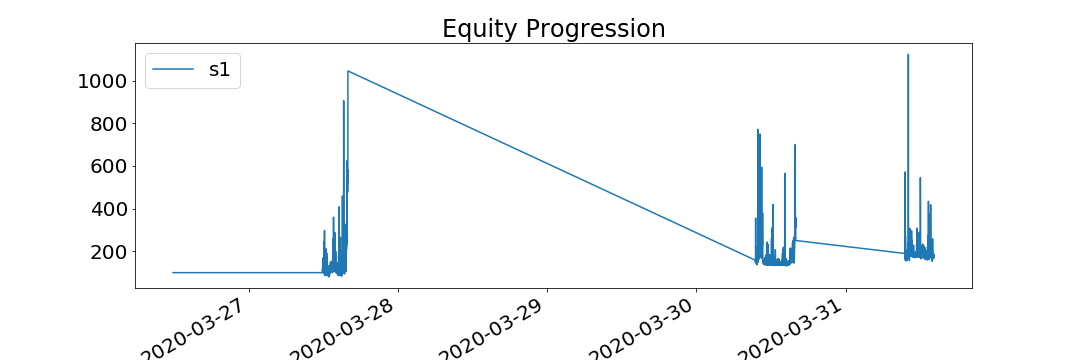

In [73]:
# first let's see an equity curve
res.plot()

In [30]:
# ok and what about some stats?
res.stats

,s1
start,2020-03-26 11:52:00-04:00
end,2020-03-31 14:12:00-04:00
rf,0
total_return,0.735632
cagr,3.10735e+17
max_drawdown,-0.834033
calmar,3.72569e+17
mtd,NaN
three_month,NaN
six_month,NaN


<IPython.core.display.Javascript object>


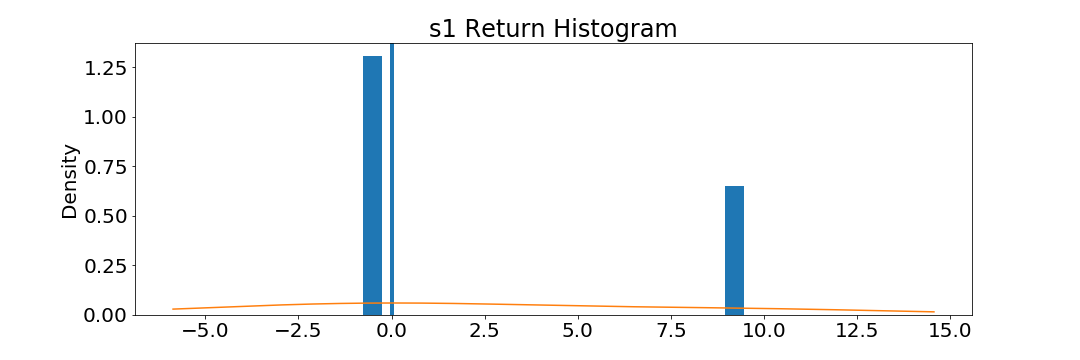

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\hist.py:309: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


In [74]:
#store gains and losses
#return distribution look like?
res.plot_histogram()

<IPython.core.display.Javascript object>


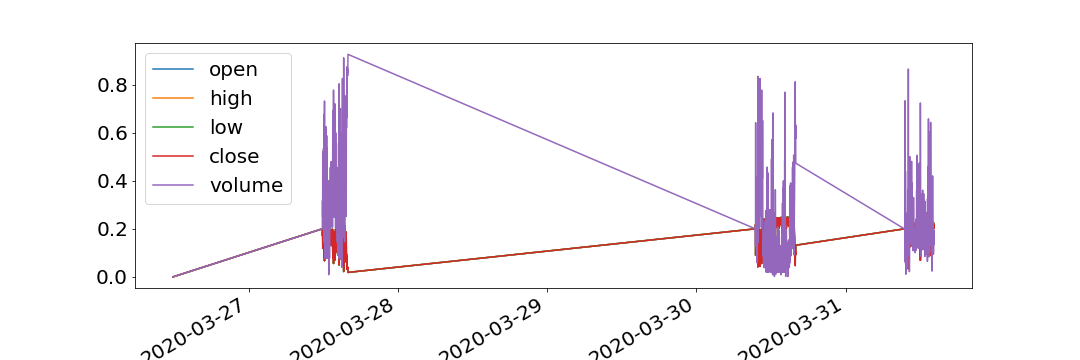

In [75]:
# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()

## pyfolio

In [27]:
#https://www.backtrader.com/docu/analyzers/pyfolio/